In [61]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet

# Prophet Model

Uses Facebook Prophet package to forecast speed of a single sensor using a decomposible time series model that takes into account many types of seasonality.

Read more: https://facebook.github.io/prophet/docs/quick_start.html#python-api



### Setup

In [8]:
station_meta = pd.read_csv('../data/processed/fwy_405_n_ds/meta.csv')

In [40]:
with open('../data/processed/fwy_405_n_ds/speeds.dat', 'rb') as f:
    station_data = pickle.load(f)

station_data.index = pd.to_datetime(station_data.index)

### Select Sensor

Choose sensor ID and split into train/test

In [41]:
# good example stations to try
#   717711  (difficult)
#   716659  (many random outliers)
#   761455  (periodic)
#   772455  (very periodic)

# select a station number to use
STATION = 772455


# use may, june as train data and july as test data
train_data = station_data[STATION][station_data.index < pd.to_datetime('2021-07-01')]
test_data = station_data[STATION][station_data.index >= pd.to_datetime('2021-07-01')]

### Model

In [47]:
# convert to fbprophet format
df = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
df.head()

# initialize model
m = Prophet(yearly_seasonality=False)
m.fit(df)

Initial log joint probability = -531.388
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         18984    0.00206106       411.586       0.346       0.346      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18994.1   0.000136275       95.1384      0.2976     0.02976      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       18995.4   0.000155277       185.997   8.319e-07       0.001      354  LS failed, Hessian reset 
     264       18996.1   5.82817e-05       66.2636   7.571e-07       0.001      428  LS failed, Hessian reset 
     299       18996.1   3.21538e-06       56.7228      0.3791           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       18996.2   0.000235759       76.0366   3.354e-06       0.001      522  LS failed, Hessian rese

### Evaluate

In [57]:
# predict test data
future = pd.DataFrame({'ds': train_data.index.union(test_data.index)})
forecast = m.predict(future)

preds = forecast[forecast['ds'].isin(test_data.index)]['yhat'].values

MAE:  14.392
RMSE: 17.077
MSE: 291.609


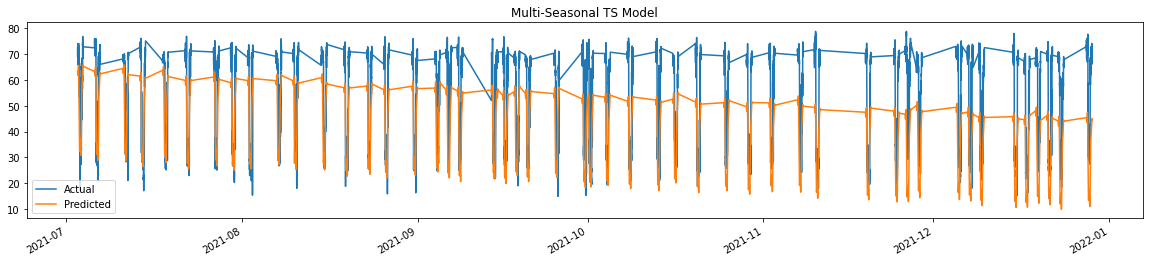

In [60]:
# results
mae = mean_absolute_error(test_data.values, preds)
rmse = mean_squared_error(test_data.values, preds, squared=False)
mse = mean_squared_error(test_data.values, preds)
print('MAE:  %.3f' % mae)
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)

p = pd.DataFrame(
    {'Actual': test_data.values, 'Predicted': preds}, 
    index=test_data.index 
).plot(figsize=(20,4), title='Multi-Seasonal TS Model')

In [63]:
# with open('./trained/prophet/metrics_prophet.dat', 'wb') as f:
#     metrics = {'mse': mse, 'rmse': rmse, 'r2': r2_score(test_data.values, preds)}
#     pickle.dump(metrics, f)

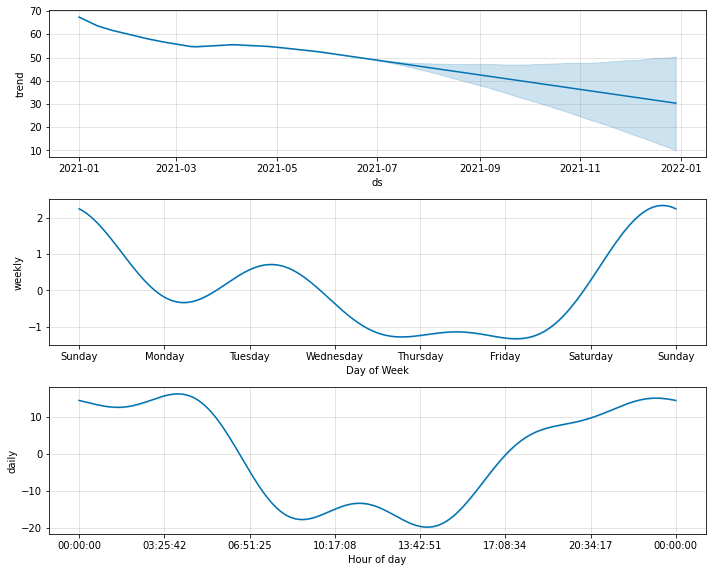

In [59]:
# model component
p = m.plot_components(forecast, figsize=(10, 8))